In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import scipy.stats
import itertools
import os
import os.path
import attila_utils
import gem_tools

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
groupdict = {
    'm-control': ('all_control', 'MSBB'),
    'm-AD': ('nosubtyping_AD', 'MSBB'),
    'm-AD-A': ('SubtypeA_AD', 'MSBB'),
    'm-AD-B1': ('SubtypeB1_AD', 'MSBB'),
    'm-AD-B2': ('SubtypeB2_AD', 'MSBB'),
    'm-AD-C1': ('SubtypeC1_AD', 'MSBB'),
    'm-AD-C2': ('SubtypeC2_AD', 'MSBB'),
    'r-control': ('all_control', 'ROSMAP'),
    'r-AD': ('nosubtyping_AD', 'ROSMAP'),
    'r-AD-A': ('SubtypeA_AD', 'ROSMAP'),
    'r-AD-B': ('SubtypeB_AD', 'ROSMAP'),
    'r-AD-C1': ('SubtypeC1_AD', 'ROSMAP'),
    'r-AD-C2': ('SubtypeC2_AD', 'ROSMAP'),
    'r-AD-other': ('Other_AD', 'ROSMAP'),
}
ar = gem_tools.read_active_reactions(groupdict)

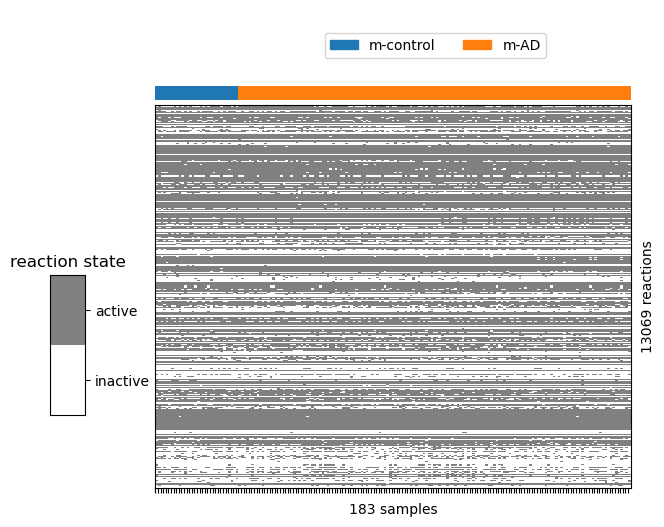

In [3]:
m_ar = {k: v for k, v in ar.items() if k in ['m-control', 'm-AD']}
g = gem_tools.ar_clustermap(None, ar=m_ar)
attila_utils.savefig(g, 'heatmap-m-control-m-AD')
del g

/Users/jonesa7/opt/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


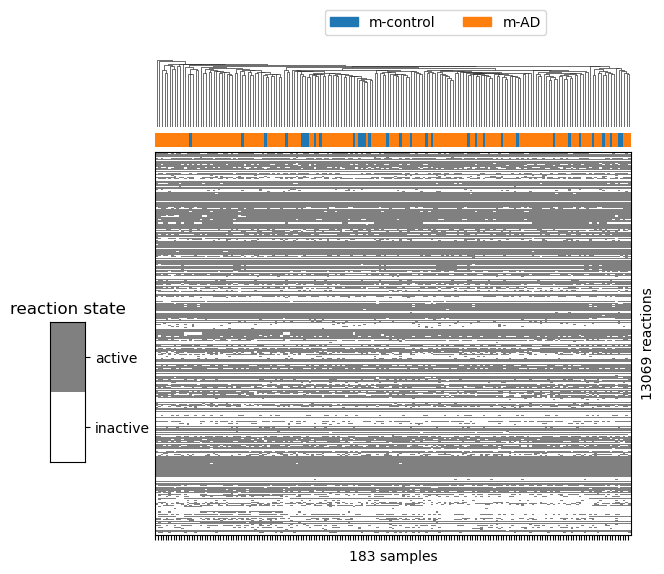

In [4]:
g = gem_tools.ar_clustermap(None, ar=m_ar, col_cluster=True)
attila_utils.savefig(g, 'clustermap-m-control-m-AD')
del g

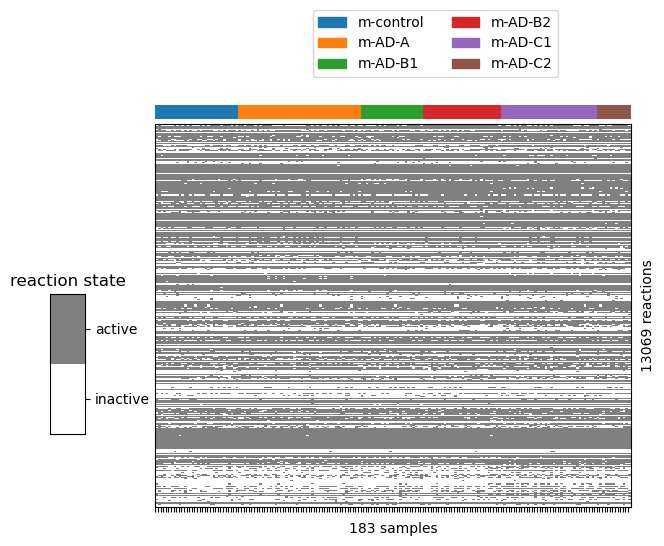

In [5]:
m_ar_sub = {k: v for k, v in ar.items() if k in ['m-control', 'm-AD-A', 'm-AD-B1', 'm-AD-B2', 'm-AD-C1', 'm-AD-C2']}
g = gem_tools.ar_clustermap(None, ar=m_ar_sub)
attila_utils.savefig(g, 'heatmap-m-control-m-AD-subtypes')
del g

/Users/jonesa7/opt/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


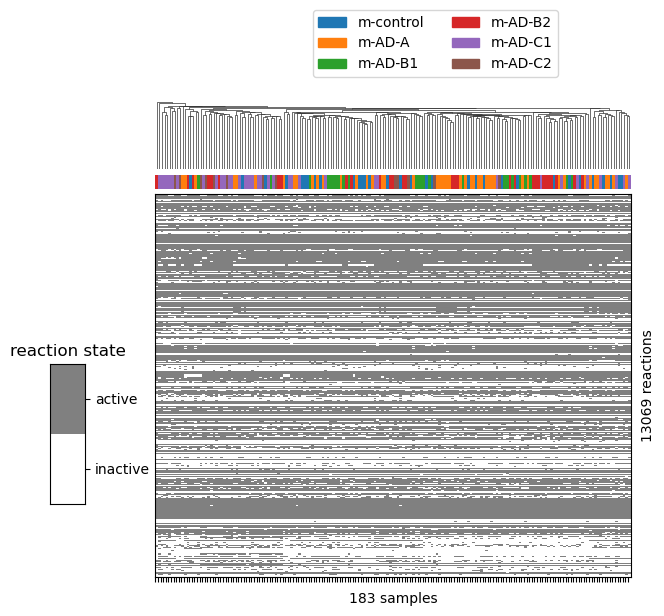

In [6]:
g = gem_tools.ar_clustermap(None, ar=m_ar_sub, col_cluster=True)
attila_utils.savefig(g, 'clustermap-m-control-m-AD-subtypes')
del g

## Similarity of groups (AD subtypes and controls)

Distance between group $A$ and $B$ is defined as the average absolute $\log_2$-odds ratio for $A$ and $B$ taken across all reactions:
\begin{equation}
d(A,B) = m^{-1} \sum_{i=1}^m \bigg | \log_2 \frac{\mathrm{odds}_i(A)}{\mathrm{odds}_i(B)} \bigg |
\end{equation}

In [7]:
def fisher_test(rxn, groupA='m-AD', groupB='m-control', ar=ar, return_odds=True):
    categories = ['active', 'inactive']
    tab = [pd.Categorical(ar[g].loc[rxn].apply(lambda b: 'active' if b else 'inactive').dropna(), categories=categories).value_counts().to_list() for g in [groupA, groupB]]
    res = list(scipy.stats.fisher_exact(tab))#[i]
    return(res)

def get_distance(groupA, groupB, ar=ar, fun=abs, do_write=True):
    if groupA == groupB:
        return(0)
    reactions = ar[list(ar.keys())[0]].index#[-100:]
    l = [fisher_test(r, groupA, groupB) for r in reactions]
    columns = ['oddsratio', 'p_value']
    df = pd.DataFrame(l, columns=columns, index=reactions)
    if do_write:
        comparison = groupA + '_wrt_' + groupB # wrt: with respect to
        fpath = '../../results/2023-02-06-AD-subtypes-active-reactions/' + 'fisher-exact-' + comparison + '.csv'
        df.to_csv(fpath)
    # filter out inf's and nan's
    df = df.applymap(lambda x: np.nan if x in [0, -np.inf, np.inf] else x).dropna()
    # take oddsratio (col 0) for distance calculation
    s = df.iloc[:, 0]
    s = s.apply(lambda x: fun(np.log2(x)))
    distance = s.sum() / len(s)
    return(distance)

In [8]:
K = groupdict.keys()
#argdf = pd.DataFrame([[tuple((a, b)) if i >= j else tuple((None, None)) for i, a in enumerate(K)] for j, b in enumerate(K)], index=K, columns=K)
argdf = pd.DataFrame([[tuple((a, b)) for a in K] for b in K], index=K, columns=K)
argdf

,m-control,m-AD,m-AD-A,m-AD-B1,m-AD-B2,m-AD-C1,m-AD-C2,r-control,r-AD,r-AD-A,r-AD-B,r-AD-C1,r-AD-C2,r-AD-other
m-control,"(m-control, m-control)","(m-AD, m-control)","(m-AD-A, m-control)","(m-AD-B1, m-control)","(m-AD-B2, m-control)","(m-AD-C1, m-control)","(m-AD-C2, m-control)","(r-control, m-control)","(r-AD, m-control)","(r-AD-A, m-control)","(r-AD-B, m-control)","(r-AD-C1, m-control)","(r-AD-C2, m-control)","(r-AD-other, m-control)"
m-AD,"(m-control, m-AD)","(m-AD, m-AD)","(m-AD-A, m-AD)","(m-AD-B1, m-AD)","(m-AD-B2, m-AD)","(m-AD-C1, m-AD)","(m-AD-C2, m-AD)","(r-control, m-AD)","(r-AD, m-AD)","(r-AD-A, m-AD)","(r-AD-B, m-AD)","(r-AD-C1, m-AD)","(r-AD-C2, m-AD)","(r-AD-other, m-AD)"
m-AD-A,"(m-control, m-AD-A)","(m-AD, m-AD-A)","(m-AD-A, m-AD-A)","(m-AD-B1, m-AD-A)","(m-AD-B2, m-AD-A)","(m-AD-C1, m-AD-A)","(m-AD-C2, m-AD-A)","(r-control, m-AD-A)","(r-AD, m-AD-A)","(r-AD-A, m-AD-A)","(r-AD-B, m-AD-A)","(r-AD-C1, m-AD-A)","(r-AD-C2, m-AD-A)","(r-AD-other, m-AD-A)"
m-AD-B1,"(m-control, m-AD-B1)","(m-AD, m-AD-B1)","(m-AD-A, m-AD-B1)","(m-AD-B1, m-AD-B1)","(m-AD-B2, m-AD-B1)","(m-AD-C1, m-AD-B1)","(m-AD-C2, m-AD-B1)","(r-control, m-AD-B1)","(r-AD, m-AD-B1)","(r-AD-A, m-AD-B1)","(r-AD-B, m-AD-B1)","(r-AD-C1, m-AD-B1)","(r-AD-C2, m-AD-B1)","(r-AD-other, m-AD-B1)"
m-AD-B2,"(m-control, m-AD-B2)","(m-AD, m-AD-B2)","(m-AD-A, m-AD-B2)","(m-AD-B1, m-AD-B2)","(m-AD-B2, m-AD-B2)","(m-AD-C1, m-AD-B2)","(m-AD-C2, m-AD-B2)","(r-control, m-AD-B2)","(r-AD, m-AD-B2)","(r-AD-A, m-AD-B2)","(r-AD-B, m-AD-B2)","(r-AD-C1, m-AD-B2)","(r-AD-C2, m-AD-B2)","(r-AD-other, m-AD-B2)"
m-AD-C1,"(m-control, m-AD-C1)","(m-AD, m-AD-C1)","(m-AD-A, m-AD-C1)","(m-AD-B1, m-AD-C1)","(m-AD-B2, m-AD-C1)","(m-AD-C1, m-AD-C1)","(m-AD-C2, m-AD-C1)","(r-control, m-AD-C1)","(r-AD, m-AD-C1)","(r-AD-A, m-AD-C1)","(r-AD-B, m-AD-C1)","(r-AD-C1, m-AD-C1)","(r-AD-C2, m-AD-C1)","(r-AD-other, m-AD-C1)"
m-AD-C2,"(m-control, m-AD-C2)","(m-AD, m-AD-C2)","(m-AD-A, m-AD-C2)","(m-AD-B1, m-AD-C2)","(m-AD-B2, m-AD-C2)","(m-AD-C1, m-AD-C2)","(m-AD-C2, m-AD-C2)","(r-control, m-AD-C2)","(r-AD, m-AD-C2)","(r-AD-A, m-AD-C2)","(r-AD-B, m-AD-C2)","(r-AD-C1, m-AD-C2)","(r-AD-C2, m-AD-C2)","(r-AD-other, m-AD-C2)"
r-control,"(m-control, r-control)","(m-AD, r-control)","(m-AD-A, r-control)","(m-AD-B1, r-control)","(m-AD-B2, r-control)","(m-AD-C1, r-control)","(m-AD-C2, r-control)","(r-control, r-control)","(r-AD, r-control)","(r-AD-A, r-control)","(r-AD-B, r-control)","(r-AD-C1, r-control)","(r-AD-C2, r-control)","(r-AD-other, r-control)"
r-AD,"(m-control, r-AD)","(m-AD, r-AD)","(m-AD-A, r-AD)","(m-AD-B1, r-AD)","(m-AD-B2, r-AD)","(m-AD-C1, r-AD)","(m-AD-C2, r-AD)","(r-control, r-AD)","(r-AD, r-AD)","(r-AD-A, r-AD)","(r-AD-B, r-AD)","(r-AD-C1, r-AD)","(r-AD-C2, r-AD)","(r-AD-other, r-AD)"
r-AD-A,"(m-control, r-AD-A)","(m-AD, r-AD-A)","(m-AD-A, r-AD-A)","(m-AD-B1, r-AD-A)","(m-AD-B2, r-AD-A)","(m-AD-C1, r-AD-A)","(m-AD-C2, r-AD-A)","(r-control, r-AD-A)","(r-AD, r-AD-A)","(r-AD-A, r-AD-A)","(r-AD-B, r-AD-A)","(r-AD-C1, r-AD-A)","(r-AD-C2, r-AD-A)","(r-AD-other, r-AD-A)"


In [9]:
def get_distance_matrix(ar=ar, fun=abs):
    fpath = '../../results/2023-02-06-AD-subtypes-active-reactions/subtype-distances.csv'
    if os.path.exists(fpath):
        print('Reading file from disk...')
        dm = pd.read_csv(fpath, index_col=0)
    else:
        print('Calculating distances...')
        dm = argdf.applymap(lambda t: get_distance(*t, ar=ar, fun=fun))
        dm.to_csv(fpath)
    return(dm)

dm = get_distance_matrix(ar=ar, fun=abs)

Reading file from disk...


/Users/jonesa7/opt/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:624: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


['named-figure/distance-matrix-subtypes-cohorts.png',
 'named-figure/distance-matrix-subtypes-cohorts.pdf']

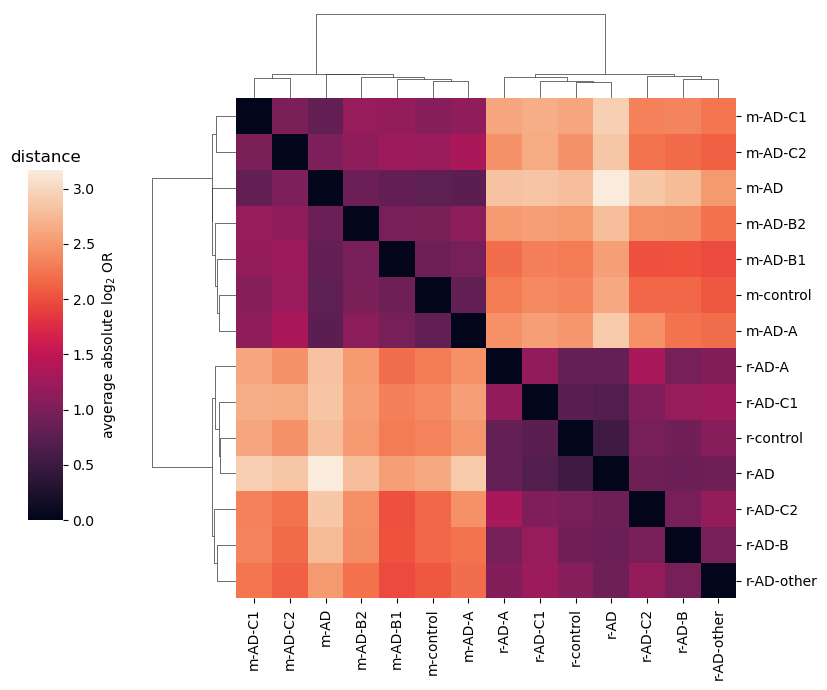

In [16]:
g = sns.clustermap(dm, figsize=(7,7), dendrogram_ratio=0.15, cbar_kws={'orientation': 'vertical'})
g.ax_cbar.set_position((-0.15, 0.25, 0.05, 0.5))
g.ax_cbar.set_ylabel(r'avgerage absolute $\log_2$ OR')
g.ax_cbar.set_title('distance')
attila_utils.savefig(g, 'distance-matrix-subtypes-cohorts')

In [11]:
%connect_info

{
  "shell_port": 64949,
  "iopub_port": 64950,
  "stdin_port": 64951,
  "control_port": 64953,
  "hb_port": 64952,
  "ip": "127.0.0.1",
  "key": "21d0d723-663255b1e5eb7e7054c64c66",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-3ca65b59-254a-4df2-a631-b16081e1eeb9.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
